# Neural Net Model for Sentence Categorization

A Neural Network model to help classify sentences as important, or not important enough to be part of a summary

Built using Keras

https://towardsdatascience.com/building-a-deep-learning-model-using-keras-1548ca149d37

In [1]:
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(2)

import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix
from os.path import join

Using TensorFlow backend.


In [2]:
FEATURES_DIR = join("..", "feature_extraction", "feature_outputs")
DATA_FILES_DIR = join("..", "feature_extraction", "data_files")
sentence_vectors_filename = join(FEATURES_DIR, "sentence_vectors.csv")
summarized_chat_log_ids_filename = join(DATA_FILES_DIR, "summarized_chat_log_ids.csv")
summarized_chat_date_partitions_filename = join(
    DATA_FILES_DIR, "summarized_chat_date_partitions_cumulative_count.csv"
)
concatenated_vectors_filename = join(DATA_FILES_DIR, "summarized_concatenated_vectors_window_5.csv")

In [3]:
# read in data using pandas. This takes a couple of seconds
# sentence_vectors_df = pd.read_csv(sentence_vectors_filename)

In [4]:
# print(sentence_vectors_df.shape)
# sentence_vectors_df.head()

In [5]:
summarized_chat_log_ids = pd.read_csv(
    summarized_chat_log_ids_filename,
    names = ["log_id", "is_summary"]
)

In [6]:
print(summarized_chat_log_ids.shape)
print(summarized_chat_log_ids.head())
print(summarized_chat_log_ids.tail())
summarized_chat_log_ids_array = np.array(summarized_chat_log_ids.log_id)
summarized_chat_log_ids_array

(20715, 2)
   log_id  is_summary
0   85350           0
1   85351           0
2   85352           0
3   85353           0
4   85354           0
       log_id  is_summary
20710  624000           0
20711  624001           0
20712  624002           0
20713  624003           0
20714  624004           0


array([ 85350,  85351,  85352, ..., 624002, 624003, 624004])

In [7]:
# summarized_sentence_vectors_df = sentence_vectors_df.filter(summarized_chat_log_ids_array, axis=0)
# summarized_num_of_columns = summarized_sentence_vectors_df.shape[0]
# # summarized_sentence_vectors_df["index"] = [num for num in range(summarized_num_of_columns)]
# # summarized_sentence_vectors_df.set_index(["index"])
# # summarized_sentence_vectors_df.reset_index
# # summarized_sentence_vectors_df.insert(0, "index", range(summarized_num_of_columns))
# print(summarized_sentence_vectors_df.shape)
# summarized_sentence_vectors_df.tail()

In [8]:
summarized_chat_date_partitions = pd.read_csv(summarized_chat_date_partitions_filename)

In [9]:
summarized_chat_date_partitions.tail(8)

,min_log_id,date_of_log,chat_line_count,cumulative_count
19,473197,2001-11-07,1990,16079
20,495175,2001-11-13,1051,17130
21,497259,2001-11-14,536,17666
22,526307,2001-11-15,1053,18719
23,531627,2001-11-12,1348,20067
24,579591,2001-10-24,162,20229
25,586206,2001-10-23,165,20394
26,623684,2001-10-25,321,20715


Get the first chat log id for the third last chat date. Use the last three chat log dates for testing. The rest to be used for training

In [10]:
index_for_validation_test_split = summarized_chat_date_partitions.tail(4)["cumulative_count"]
index_for_validation_test_split = index_for_validation_test_split.values[0]
index_for_train_validation_split = summarized_chat_date_partitions.tail(8)["cumulative_count"]
index_for_train_validation_split = index_for_train_validation_split.values[0]
print(index_for_train_validation_split)
index_for_validation_test_split

16079


20067

Concatenate sentence vectors for context

In [11]:
def concatenate_sentence_vectors(data_values, window):
    number_of_rows, number_of_columns = data_values.shape
    eventual_number_of_columns = number_of_columns +(number_of_columns * window * 2)
    new_np_data = np.array([]).reshape(0, eventual_number_of_columns)
    
    for index in range(data_values.shape[0]):
        first_index = index - window
        last_index = index + window
        start_padding = []
        end_padding = []
        
        if first_index < 0:
            start_padding = np.zeros((abs(first_index), number_of_columns))
            first_index = 0
        if last_index >= number_of_rows:
            end_padding = np.zeros((((last_index - number_of_rows) + 1), number_of_columns))
            last_index = number_of_rows - 1
            
        concatenated_row = data_values[first_index:last_index+1]
        # print("\n", index, "\n", concatenated_row, start_padding, "\n\n")
        if len(start_padding) > 0:
            # print(start_padding.shape, data_values[first_index: first_index+1].shape)
            concatenated_row = np.concatenate((start_padding, concatenated_row))
        if len(end_padding) > 0:
            # print(end_padding.shape, data_values[first_index: first_index+1].shape)
            concatenated_row = np.concatenate((concatenated_row, end_padding))
        concatenated_row = concatenated_row.ravel()
        # print(index, concatenated_row, "\n\n")
        # print(concatenated_row.shape, new_np_data.shape)
        new_np_data = np.concatenate((new_np_data, concatenated_row))
    return pd.DataFrame(new_np_data)

In [12]:
start = time.time()
# summarized_sentence_vectors_array = summarized_sentence_vectors_df.values
context_window = 5

# This takes about 40 minutes, or 2386.799 seconds
# concatenated_sentence_vectors_df = concatenate_sentence_vectors(summarized_sentence_vectors_array, context_window)
end = time.time()
print(end - start)

8.392333984375e-05


In [15]:
# concatenated_sentence_vectors_df = pd.read_csv(concatenated_vectors_filename)

In [16]:
# concatenated_sentence_vectors_df = concatenated_sentence_vectors_df.drop(columns=[0])
# concatenated_sentence_vectors_df.to_csv(concatenated_vectors_filename)
# concatenated_sentence_vectors_df.head(6)

In [17]:
# concatenated_sentence_vectors_df.tail(6)

In [18]:
# concatenated_sentence_vectors_df = concatenated_sentence_vectors_df.drop(columns=["Unnamed: 0"])
# concatenated_sentence_vectors_df.head(2)

In [319]:
# print(summarized_sentence_vectors_df.shape)
# summarized_sentence_vectors_df.tail()

In [13]:
FEATURES_DATA_FILE = join(FEATURES_DIR, "summarized_chats_features.csv")
# read in data using pandas
unnormalized_chat_log_df = pd.read_csv(FEATURES_DATA_FILE)

In [14]:
unnormalized_chat_log_df.tail()
# unnormalized_chat_log_df.insert(0, "index", range(unnormalized_chat_log_df.shape[0]))
# print(unnormalized_chat_log_df.loc[0:5])
unnormalized_chat_log_df.sentiment_score = abs(unnormalized_chat_log_df.sentiment_score)
unnormalized_chat_log_df.head()


,log_id,absolute_sentence_position,sentence_length,number_of_special_terms,sentiment_score,mean_tf_idf,normalized_mean_tf_idf,mean_tf_isf,normalized_mean_tf_isf,is_summary
0,85350,0.000436,1,0,0.6249,0.000789,0.006050,2.758723,0.788992,0
1,85351,0.000871,13,0,0.0000,0.003486,0.026734,0.149401,0.042729,0
2,85352,0.001307,10,0,0.0000,0.004054,0.031086,0.180867,0.051728,0
3,85353,0.001743,5,0,0.0000,0.003645,0.027952,0.499669,0.142905,0
4,85354,0.002179,8,0,0.2263,0.002310,0.017715,0.295432,0.084493,0


In [15]:
# unnormalized_merged_log_data_df = pd.merge(
#     unnormalized_chat_log_df, 
#     summarized_sentence_vectors_df, 
#     left_on="log_id",
#     right_index=True
# )
# print(unnormalized_merged_log_data_df.shape)
# unnormalized_merged_log_data_df.head()

### Normalizing The Data
Formula to normalize data
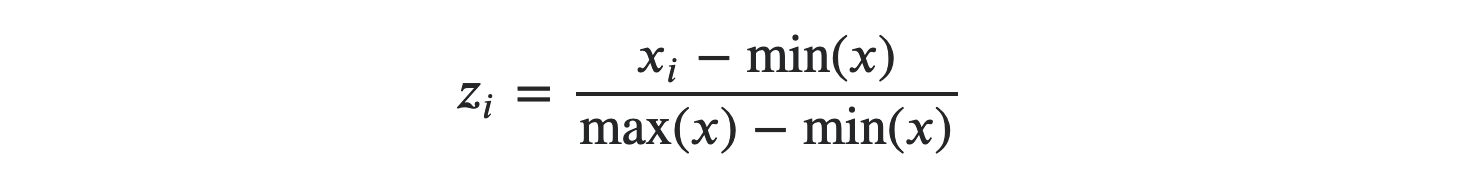

In [16]:
chat_data_max_values = unnormalized_chat_log_df.max()
chat_data_min_values = unnormalized_chat_log_df.min()

max_number_of_special_terms = chat_data_max_values.number_of_special_terms
max_sentence_length = chat_data_max_values.sentence_length
max_sentiment_score = chat_data_max_values.sentiment_score
max_absolute_sentence_position = chat_data_max_values.absolute_sentence_position
max_mean_tf_idf = chat_data_max_values.mean_tf_idf
max_mean_tf_isf = chat_data_max_values.mean_tf_isf
max_normalized_mean_tf_idf = chat_data_max_values.normalized_mean_tf_idf
max_normalized_mean_tf_isf = chat_data_max_values.normalized_mean_tf_isf

min_number_of_special_terms = chat_data_min_values.number_of_special_terms
min_sentence_length = chat_data_min_values.sentence_length
min_sentiment_score = chat_data_min_values.sentiment_score
min_absolute_sentence_position = chat_data_min_values.absolute_sentence_position
min_mean_tf_idf = chat_data_min_values.mean_tf_idf
min_mean_tf_isf = chat_data_min_values.mean_tf_isf
min_normalized_mean_tf_idf = chat_data_min_values.normalized_mean_tf_idf
min_normalized_mean_tf_isf = chat_data_min_values.normalized_mean_tf_isf

print(min_sentiment_score)
print(max_sentiment_score)
print(min_absolute_sentence_position)
print(max_absolute_sentence_position)
print(min_mean_tf_idf)
print(min_mean_tf_isf)
print(min_normalized_mean_tf_idf)
print(min_normalized_mean_tf_isf)
print(max_mean_tf_idf)
print(max_mean_tf_isf)
print(max_normalized_mean_tf_idf)
print(max_normalized_mean_tf_isf)
max_sentence_length

0.0
0.9707
0.00043572984749455336
1.0
0.0
0.0
0.0
0.0
0.04073392898973263
3.36078268987328
0.3123448778466237
0.9611808193277522


73.0

In [17]:
chat_log_df = unnormalized_chat_log_df.copy()
chat_log_df.sentence_length = (
    chat_log_df.sentence_length - min_sentence_length) / (
    max_sentence_length - min_sentence_length)
chat_log_df.number_of_special_terms = (
    chat_log_df.number_of_special_terms - min_number_of_special_terms) / (
    max_number_of_special_terms - min_number_of_special_terms)
chat_log_df.sentiment_score = (
    chat_log_df.sentiment_score - min_sentiment_score) / (
    max_sentiment_score - min_sentiment_score)
chat_log_df.absolute_sentence_position = (
    chat_log_df.absolute_sentence_position - min_absolute_sentence_position) / (
    max_absolute_sentence_position - min_absolute_sentence_position)
chat_log_df.mean_tf_idf = (
    chat_log_df.mean_tf_idf - min_mean_tf_idf) / (
    max_mean_tf_idf - min_mean_tf_idf)
chat_log_df.mean_tf_isf = (
    chat_log_df.mean_tf_isf - min_mean_tf_isf) / (
    max_mean_tf_isf - min_mean_tf_isf)
chat_log_df.normalized_mean_tf_idf = (
    chat_log_df.normalized_mean_tf_idf - min_normalized_mean_tf_idf) / (
    max_normalized_mean_tf_idf - min_normalized_mean_tf_idf)
chat_log_df.normalized_mean_tf_isf = (
    chat_log_df.normalized_mean_tf_isf - min_normalized_mean_tf_isf) / (
    max_normalized_mean_tf_isf - min_normalized_mean_tf_isf)

print(chat_log_df.sentence_length.head())
chat_log_df.iloc[0:5]
# chat_log_df.head()

0    0.013699
1    0.178082
2    0.136986
3    0.068493
4    0.109589
Name: sentence_length, dtype: float64


,log_id,absolute_sentence_position,sentence_length,number_of_special_terms,sentiment_score,mean_tf_idf,normalized_mean_tf_idf,mean_tf_isf,normalized_mean_tf_isf,is_summary
0,85350,0.000000,0.013699,0.0,0.643762,0.019369,0.019369,0.820857,0.820857,0
1,85351,0.000436,0.178082,0.0,0.000000,0.085591,0.085591,0.044454,0.044454,0
2,85352,0.000872,0.136986,0.0,0.000000,0.099525,0.099525,0.053817,0.053817,0
3,85353,0.001308,0.068493,0.0,0.000000,0.089492,0.089492,0.148677,0.148677,0
4,85354,0.001744,0.109589,0.0,0.233131,0.056715,0.056715,0.087906,0.087906,0


In [18]:
train_df = chat_log_df.iloc[:index_for_train_validation_split]
validation_df = chat_log_df.iloc[index_for_train_validation_split:index_for_validation_test_split]
test_df = chat_log_df.iloc[index_for_validation_test_split:]
train_df.tail()

# Sentence Vectors only
# train_vectors_df = summarized_sentence_vectors_df.iloc[:index_for_train_validation_split]
# validation_vectors_df = summarized_sentence_vectors_df.iloc[index_for_train_validation_split:index_for_validation_test_split]
# test_vectors_df = summarized_sentence_vectors_df.iloc[index_for_validation_test_split:]
# train_vectors_df.tail()

,log_id,absolute_sentence_position,sentence_length,number_of_special_terms,sentiment_score,mean_tf_idf,normalized_mean_tf_idf,mean_tf_isf,normalized_mean_tf_isf,is_summary
16074,475182,0.997989,0.136986,0.0,0.208406,0.081768,0.081768,0.059544,0.059544,0
16075,475183,0.998492,0.013699,0.0,0.000000,0.052944,0.052944,0.712859,0.712859,0
16076,475184,0.998995,0.027397,0.0,0.233131,0.050432,0.050432,0.269761,0.269761,0
16077,475185,0.999497,0.013699,0.0,0.656124,0.110526,0.110526,0.522136,0.522136,0
16078,475186,1.000000,0.082192,0.0,0.230761,0.096316,0.096316,0.080129,0.080129,0


In [19]:
validation_df.head()

,log_id,absolute_sentence_position,sentence_length,number_of_special_terms,sentiment_score,mean_tf_idf,normalized_mean_tf_idf,mean_tf_isf,normalized_mean_tf_isf,is_summary
16079,495175,0.000516,0.150685,0.000000,0.472649,0.050304,0.050304,0.051808,0.051808,0
16080,495176,0.001468,0.013699,0.000000,0.000000,0.020250,0.020250,0.899077,0.899077,0
16081,495177,0.002420,0.000000,0.000000,0.472649,0.000000,0.000000,0.000000,0.000000,0
16082,495178,0.003372,0.136986,0.054054,0.000000,0.040161,0.040161,0.063344,0.063344,0
16083,495179,0.004324,0.054795,0.000000,0.472649,0.038080,0.038080,0.131802,0.131802,0


In [20]:
validation_df.tail()

,log_id,absolute_sentence_position,sentence_length,number_of_special_terms,sentiment_score,mean_tf_idf,normalized_mean_tf_idf,mean_tf_isf,normalized_mean_tf_isf,is_summary
20062,532970,0.997031,0.013699,0.0,0.000000,0.043630,0.043630,0.931238,0.931238,0
20063,532971,0.997774,0.041096,0.0,0.000000,0.099908,0.099908,0.230029,0.230029,0
20064,532972,0.998516,0.013699,0.0,0.542598,0.057936,0.057936,0.752096,0.752096,0
20065,532973,0.999258,0.068493,0.0,0.257546,0.065927,0.065927,0.105421,0.105421,0
20066,532974,1.000000,0.027397,0.0,0.000000,0.022086,0.022086,0.340556,0.340556,0


In [21]:
test_df.head()

,log_id,absolute_sentence_position,sentence_length,number_of_special_terms,sentiment_score,mean_tf_idf,normalized_mean_tf_idf,mean_tf_isf,normalized_mean_tf_isf,is_summary
20067,579591,0.005740,0.232877,0.0,0.617493,0.014957,0.014957,0.029834,0.029834,0
20068,579592,0.011915,0.027397,0.0,0.304935,0.002195,0.002195,0.328720,0.328720,0
20069,579593,0.018091,0.041096,0.0,0.304935,0.010781,0.010781,0.191207,0.191207,0
20070,579594,0.024266,0.000000,0.0,0.453693,0.000000,0.000000,0.000000,0.000000,0
20071,579595,0.030442,0.027397,0.0,0.000000,0.013585,0.013585,0.283935,0.283935,0


In [22]:
# check data has been read in properly
test_df.tail()

,log_id,absolute_sentence_position,sentence_length,number_of_special_terms,sentiment_score,mean_tf_idf,normalized_mean_tf_idf,mean_tf_isf,normalized_mean_tf_isf,is_summary
20710,624000,0.987534,0.027397,0.0,0.000000,0.010594,0.010594,0.292627,0.292627,0
20711,624001,0.990650,0.054795,0.0,0.000000,0.019673,0.019673,0.132364,0.132364,0
20712,624002,0.993767,0.095890,0.0,0.542598,0.027545,0.027545,0.091081,0.091081,0
20713,624003,0.996883,0.000000,0.0,0.472649,0.000000,0.000000,0.000000,0.000000,0
20714,624004,1.000000,0.013699,0.0,0.000000,0.019725,0.019725,0.656239,0.656239,0


In [23]:
#create a dataframe with all training data except the target column
columns_to_drop = ["log_id", "is_summary", "mean_tf_idf", "mean_tf_isf", "number_of_special_terms"]
# Keep only normalized columns
train_X = train_df.drop(columns=columns_to_drop)
validation_X = validation_df.drop(columns=columns_to_drop)
test_X = test_df.drop(columns=columns_to_drop)

assert train_X.shape[1] == test_X.shape[1] and test_X.shape[1] == validation_X.shape[1] 
#check that the target variable has been removed
print(train_X.shape)
train_X.head()

(16079, 5)


,absolute_sentence_position,sentence_length,sentiment_score,normalized_mean_tf_idf,normalized_mean_tf_isf
0,0.000000,0.013699,0.643762,0.019369,0.820857
1,0.000436,0.178082,0.000000,0.085591,0.044454
2,0.000872,0.136986,0.000000,0.099525,0.053817
3,0.001308,0.068493,0.000000,0.089492,0.148677
4,0.001744,0.109589,0.233131,0.056715,0.087906


In [24]:
# vector_columns = [str(num) for num in range(1, 151)]
# train_X_no_vectors = train_X.drop(columns=vector_columns)
# validation_X_no_vectors = validation_X.drop(columns=vector_columns)
# test_X_no_vectors = test_X.drop(columns=vector_columns)

In [25]:
# print(train_X_no_vectors.shape)
# assert train_X_no_vectors.shape[1] == validation_X_no_vectors.shape[1] 
# assert validation_X_no_vectors.shape[1] == test_X_no_vectors.shape[1]
# train_X_no_vectors.head()

In [26]:
print(validation_X.shape)
validation_X.head()

(3988, 5)


,absolute_sentence_position,sentence_length,sentiment_score,normalized_mean_tf_idf,normalized_mean_tf_isf
16079,0.000516,0.150685,0.472649,0.050304,0.051808
16080,0.001468,0.013699,0.000000,0.020250,0.899077
16081,0.002420,0.000000,0.472649,0.000000,0.000000
16082,0.003372,0.136986,0.000000,0.040161,0.063344
16083,0.004324,0.054795,0.472649,0.038080,0.131802


In [27]:
print(test_X.shape)
test_X.head()

(648, 5)


,absolute_sentence_position,sentence_length,sentiment_score,normalized_mean_tf_idf,normalized_mean_tf_isf
20067,0.005740,0.232877,0.617493,0.014957,0.029834
20068,0.011915,0.027397,0.304935,0.002195,0.328720
20069,0.018091,0.041096,0.304935,0.010781,0.191207
20070,0.024266,0.000000,0.453693,0.000000,0.000000
20071,0.030442,0.027397,0.000000,0.013585,0.283935


In [28]:
train_df.is_summary.values

array([0, 0, 0, ..., 0, 0, 0])

When separating the target column, we need to call the `to_categorical()` function so that column will be `one-hot encoded`. Currently, a chat line that is not a summary is represented with a `0` in the `is_summary` column and a chat line that is a summary is represented with a `1`. With one-hot encoding, the integer will be removed and a binary variable is inputted for each category.

In [29]:
# create a one hot encoding for the target column
train_y = to_categorical(train_df.is_summary)
train_y_nums = train_df.is_summary.values
validation_y = to_categorical(validation_df.is_summary)
validation_y_nums = validation_df.is_summary.values
test_y = to_categorical(test_df.is_summary)
test_y_nums = test_df.is_summary.values
# view one hot encoding numpy array
print(train_y_nums)
train_y[415: 425]

[0 0 0 ... 0 0 0]


array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.]], dtype=float32)

In [30]:
print(train_y.shape)
print(validation_y.shape)
print(test_y.shape)

(16079, 2)
(3988, 2)
(648, 2)


In [31]:
test_y[5:10]

array([[1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

The activation is `softmax`. Softmax makes the output sum up to `1` so the output can be interpreted as probabilities. The model will then make its prediction based on which option has a higher probability.

In [32]:

#create model
model = Sequential()

#get number of columns in training data
# n_cols = train_vectors_df.shape[1]
n_cols = train_X.shape[1]

#add model layers
model.add(Dense(n_cols, activation='relu', input_shape=(n_cols,)))
model.add(Dense(50, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(50, activation='relu'))
# model.add(Dense(300, activation='relu'))
model.add(Dense(2, activation='softmax'))

Instructions for updating:
Colocations handled automatically by placer.


In [33]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 5)                 30        
_________________________________________________________________
dense_2 (Dense)              (None, 50)                300       
_________________________________________________________________
dense_3 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_4 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 102       
Total params: 5,532
Trainable params: 5,532
Non-trainable params: 0
_________________________________________________________________


We will use `categorical_crossentropy` for our loss function. This is the most common choice for classification. A lower score indicates that the model is performing better.

We will use the ‘mean absolute error’ metric to see the score on the validation set at the end of each epoch.

In [34]:
#compile model using mse as a measure of model performance
model.compile(
    optimizer='adam', 
    loss='categorical_crossentropy', 
    metrics=['accuracy']
)


In [35]:
#set early stopping monitor so the model stops training when it won't improve anymore
# early_stopping_monitor = EarlyStopping(patience=3)

In [36]:
#train model
# Takes about 5230.725239038467  seconds About 1 and 1/2 hours for 1000 epochs
start = time.time()
history = model.fit(
    train_X,
    # train_X_no_vectors, 
    train_y, 
    epochs=1000,
    # validation_split=0.4
    validation_data=(validation_X, validation_y)
    
)
end = time.time()
print(end-start, " seconds")

Instructions for updating:
Use tf.cast instead.
Train on 16079 samples, validate on 3988 samples
Epoch 1/1000
16079/16079 [==============================] - 2s 119us/step - loss: 0.1579 - acc: 0.9676 - val_loss: 0.1290 - val_acc: 0.9709
Epoch 2/1000
16079/16079 [==============================] - 1s 82us/step - loss: 0.1332 - acc: 0.9684 - val_loss: 0.1333 - val_acc: 0.9709
Epoch 3/1000
16079/16079 [==============================] - 1s 65us/step - loss: 0.1333 - acc: 0.9684 - val_loss: 0.1323 - val_acc: 0.9709
Epoch 4/1000
16079/16079 [==============================] - 1s 73us/step - loss: 0.1334 - acc: 0.9684 - val_loss: 0.1281 - val_acc: 0.9709
Epoch 5/1000
16079/16079 [==============================] - 1s 68us/step - loss: 0.1327 - acc: 0.9684 - val_loss: 0.1283 - val_acc: 0.9709
Epoch 6/1000
16079/16079 [==============================] - 1s 78us/step - loss: 0.1327 - acc: 0.9684 - val_loss: 0.1290 - val_acc: 0.9709
Epoch 7/1000
16079/16079 [==============================] - 1s 75us/

16079/16079 [==============================] - 2s 95us/step - loss: 0.1293 - acc: 0.9684 - val_loss: 0.1300 - val_acc: 0.9709
Epoch 58/1000
16079/16079 [==============================] - 1s 87us/step - loss: 0.1296 - acc: 0.9684 - val_loss: 0.1294 - val_acc: 0.9709
Epoch 59/1000
16079/16079 [==============================] - 1s 78us/step - loss: 0.1294 - acc: 0.9684 - val_loss: 0.1303 - val_acc: 0.9709
Epoch 60/1000
16079/16079 [==============================] - 1s 77us/step - loss: 0.1294 - acc: 0.9684 - val_loss: 0.1300 - val_acc: 0.9709
Epoch 61/1000
16079/16079 [==============================] - 1s 78us/step - loss: 0.1294 - acc: 0.9684 - val_loss: 0.1300 - val_acc: 0.9709
Epoch 62/1000
16079/16079 [==============================] - 1s 76us/step - loss: 0.1292 - acc: 0.9684 - val_loss: 0.1301 - val_acc: 0.9709
Epoch 63/1000
16079/16079 [==============================] - 1s 71us/step - loss: 0.1291 - acc: 0.9684 - val_loss: 0.1296 - val_acc: 0.9709
Epoch 64/1000
16079/16079 [=======

16079/16079 [==============================] - 1s 67us/step - loss: 0.1274 - acc: 0.9684 - val_loss: 0.1330 - val_acc: 0.9709
Epoch 116/1000
16079/16079 [==============================] - 1s 77us/step - loss: 0.1274 - acc: 0.9684 - val_loss: 0.1324 - val_acc: 0.9709
Epoch 117/1000
16079/16079 [==============================] - 1s 69us/step - loss: 0.1274 - acc: 0.9684 - val_loss: 0.1311 - val_acc: 0.9709
Epoch 118/1000
16079/16079 [==============================] - 1s 63us/step - loss: 0.1272 - acc: 0.9684 - val_loss: 0.1341 - val_acc: 0.9709
Epoch 119/1000
16079/16079 [==============================] - 1s 71us/step - loss: 0.1273 - acc: 0.9684 - val_loss: 0.1330 - val_acc: 0.9709
Epoch 120/1000
16079/16079 [==============================] - 1s 66us/step - loss: 0.1272 - acc: 0.9684 - val_loss: 0.1318 - val_acc: 0.9709
Epoch 121/1000
16079/16079 [==============================] - 1s 72us/step - loss: 0.1271 - acc: 0.9684 - val_loss: 0.1309 - val_acc: 0.9709
Epoch 122/1000
16079/16079 [

16079/16079 [==============================] - 1s 76us/step - loss: 0.1250 - acc: 0.9684 - val_loss: 0.1344 - val_acc: 0.9709
Epoch 174/1000
16079/16079 [==============================] - 1s 67us/step - loss: 0.1255 - acc: 0.9684 - val_loss: 0.1334 - val_acc: 0.9709
Epoch 175/1000
16079/16079 [==============================] - 1s 73us/step - loss: 0.1256 - acc: 0.9684 - val_loss: 0.1353 - val_acc: 0.9709
Epoch 176/1000
16079/16079 [==============================] - 1s 61us/step - loss: 0.1251 - acc: 0.9684 - val_loss: 0.1357 - val_acc: 0.9709
Epoch 177/1000
16079/16079 [==============================] - 1s 66us/step - loss: 0.1253 - acc: 0.9684 - val_loss: 0.1378 - val_acc: 0.9709
Epoch 178/1000
16079/16079 [==============================] - 1s 65us/step - loss: 0.1253 - acc: 0.9684 - val_loss: 0.1405 - val_acc: 0.9709
Epoch 179/1000
16079/16079 [==============================] - 1s 68us/step - loss: 0.1250 - acc: 0.9684 - val_loss: 0.1373 - val_acc: 0.9709
Epoch 180/1000
16079/16079 [

16079/16079 [==============================] - 1s 78us/step - loss: 0.1241 - acc: 0.9684 - val_loss: 0.1410 - val_acc: 0.9709
Epoch 232/1000
16079/16079 [==============================] - 1s 81us/step - loss: 0.1240 - acc: 0.9684 - val_loss: 0.1431 - val_acc: 0.9709
Epoch 233/1000
16079/16079 [==============================] - 2s 98us/step - loss: 0.1241 - acc: 0.9684 - val_loss: 0.1412 - val_acc: 0.9709
Epoch 234/1000
16079/16079 [==============================] - 1s 67us/step - loss: 0.1245 - acc: 0.9684 - val_loss: 0.1413 - val_acc: 0.9709
Epoch 235/1000
16079/16079 [==============================] - 1s 63us/step - loss: 0.1235 - acc: 0.9684 - val_loss: 0.1393 - val_acc: 0.9709
Epoch 236/1000
16079/16079 [==============================] - 1s 75us/step - loss: 0.1241 - acc: 0.9684 - val_loss: 0.1411 - val_acc: 0.9709
Epoch 237/1000
16079/16079 [==============================] - 1s 67us/step - loss: 0.1237 - acc: 0.9684 - val_loss: 0.1376 - val_acc: 0.9709
Epoch 238/1000
16079/16079 [

16079/16079 [==============================] - 1s 71us/step - loss: 0.1225 - acc: 0.9684 - val_loss: 0.1393 - val_acc: 0.9709
Epoch 290/1000
16079/16079 [==============================] - 1s 81us/step - loss: 0.1230 - acc: 0.9684 - val_loss: 0.1401 - val_acc: 0.9709
Epoch 291/1000
16079/16079 [==============================] - 1s 71us/step - loss: 0.1220 - acc: 0.9684 - val_loss: 0.1468 - val_acc: 0.9709
Epoch 292/1000
16079/16079 [==============================] - 1s 74us/step - loss: 0.1224 - acc: 0.9684 - val_loss: 0.1472 - val_acc: 0.9709
Epoch 293/1000
16079/16079 [==============================] - 1s 67us/step - loss: 0.1221 - acc: 0.9684 - val_loss: 0.1454 - val_acc: 0.9709
Epoch 294/1000
16079/16079 [==============================] - 1s 69us/step - loss: 0.1224 - acc: 0.9684 - val_loss: 0.1424 - val_acc: 0.9709
Epoch 295/1000
16079/16079 [==============================] - 1s 71us/step - loss: 0.1225 - acc: 0.9684 - val_loss: 0.1383 - val_acc: 0.9709
Epoch 296/1000
16079/16079 [

16079/16079 [==============================] - 2s 97us/step - loss: 0.1205 - acc: 0.9684 - val_loss: 0.1605 - val_acc: 0.9707
Epoch 348/1000
16079/16079 [==============================] - 1s 80us/step - loss: 0.1203 - acc: 0.9685 - val_loss: 0.1571 - val_acc: 0.9707
Epoch 349/1000
16079/16079 [==============================] - 1s 93us/step - loss: 0.1217 - acc: 0.9684 - val_loss: 0.1427 - val_acc: 0.9707
Epoch 350/1000
16079/16079 [==============================] - 1s 77us/step - loss: 0.1205 - acc: 0.9685 - val_loss: 0.1498 - val_acc: 0.9707
Epoch 351/1000
16079/16079 [==============================] - 1s 78us/step - loss: 0.1209 - acc: 0.9685 - val_loss: 0.1466 - val_acc: 0.9704
Epoch 352/1000
16079/16079 [==============================] - 1s 80us/step - loss: 0.1202 - acc: 0.9683 - val_loss: 0.1512 - val_acc: 0.9704
Epoch 353/1000
16079/16079 [==============================] - 1s 88us/step - loss: 0.1206 - acc: 0.9685 - val_loss: 0.1495 - val_acc: 0.9707
Epoch 354/1000
16079/16079 [

16079/16079 [==============================] - 1s 74us/step - loss: 0.1187 - acc: 0.9687 - val_loss: 0.1543 - val_acc: 0.9702
Epoch 406/1000
16079/16079 [==============================] - 1s 72us/step - loss: 0.1182 - acc: 0.9685 - val_loss: 0.1584 - val_acc: 0.9697
Epoch 407/1000
16079/16079 [==============================] - 1s 70us/step - loss: 0.1188 - acc: 0.9685 - val_loss: 0.1517 - val_acc: 0.9699
Epoch 408/1000
16079/16079 [==============================] - 1s 82us/step - loss: 0.1186 - acc: 0.9687 - val_loss: 0.1512 - val_acc: 0.9699
Epoch 409/1000
16079/16079 [==============================] - 1s 62us/step - loss: 0.1185 - acc: 0.9687 - val_loss: 0.1564 - val_acc: 0.9704
Epoch 410/1000
16079/16079 [==============================] - 1s 82us/step - loss: 0.1184 - acc: 0.9685 - val_loss: 0.1575 - val_acc: 0.9704
Epoch 411/1000
16079/16079 [==============================] - 1s 66us/step - loss: 0.1187 - acc: 0.9686 - val_loss: 0.1516 - val_acc: 0.9704
Epoch 412/1000
16079/16079 [

16079/16079 [==============================] - 1s 68us/step - loss: 0.1166 - acc: 0.9688 - val_loss: 0.1527 - val_acc: 0.9702
Epoch 464/1000
16079/16079 [==============================] - 1s 77us/step - loss: 0.1170 - acc: 0.9687 - val_loss: 0.1598 - val_acc: 0.9699
Epoch 465/1000
16079/16079 [==============================] - 1s 86us/step - loss: 0.1163 - acc: 0.9687 - val_loss: 0.1560 - val_acc: 0.9704
Epoch 466/1000
16079/16079 [==============================] - 1s 80us/step - loss: 0.1181 - acc: 0.9687 - val_loss: 0.1610 - val_acc: 0.9702
Epoch 467/1000
16079/16079 [==============================] - 1s 77us/step - loss: 0.1166 - acc: 0.9688 - val_loss: 0.1536 - val_acc: 0.9704
Epoch 468/1000
16079/16079 [==============================] - 1s 73us/step - loss: 0.1169 - acc: 0.9685 - val_loss: 0.1634 - val_acc: 0.9704
Epoch 469/1000
16079/16079 [==============================] - 1s 81us/step - loss: 0.1189 - acc: 0.9684 - val_loss: 0.1510 - val_acc: 0.9704
Epoch 470/1000
16079/16079 [

16079/16079 [==============================] - 1s 90us/step - loss: 0.1150 - acc: 0.9687 - val_loss: 0.1610 - val_acc: 0.9697
Epoch 522/1000
16079/16079 [==============================] - 1s 75us/step - loss: 0.1146 - acc: 0.9690 - val_loss: 0.1592 - val_acc: 0.9699
Epoch 523/1000
16079/16079 [==============================] - 2s 101us/step - loss: 0.1146 - acc: 0.9690 - val_loss: 0.1595 - val_acc: 0.9702
Epoch 524/1000
16079/16079 [==============================] - 1s 75us/step - loss: 0.1150 - acc: 0.9687 - val_loss: 0.1624 - val_acc: 0.9699
Epoch 525/1000
16079/16079 [==============================] - 2s 95us/step - loss: 0.1151 - acc: 0.9687 - val_loss: 0.1622 - val_acc: 0.9697
Epoch 526/1000
16079/16079 [==============================] - 1s 86us/step - loss: 0.1147 - acc: 0.9688 - val_loss: 0.1617 - val_acc: 0.9697
Epoch 527/1000
16079/16079 [==============================] - 1s 86us/step - loss: 0.1148 - acc: 0.9688 - val_loss: 0.1598 - val_acc: 0.9699
Epoch 528/1000
16079/16079 

16079/16079 [==============================] - 1s 81us/step - loss: 0.1131 - acc: 0.9688 - val_loss: 0.1640 - val_acc: 0.9694
Epoch 580/1000
16079/16079 [==============================] - 1s 75us/step - loss: 0.1140 - acc: 0.9688 - val_loss: 0.1721 - val_acc: 0.9694
Epoch 581/1000
16079/16079 [==============================] - 1s 73us/step - loss: 0.1151 - acc: 0.9685 - val_loss: 0.1688 - val_acc: 0.9697
Epoch 582/1000
16079/16079 [==============================] - 1s 76us/step - loss: 0.1124 - acc: 0.9690 - val_loss: 0.1651 - val_acc: 0.9692
Epoch 583/1000
16079/16079 [==============================] - 1s 64us/step - loss: 0.1118 - acc: 0.9686 - val_loss: 0.1610 - val_acc: 0.9699
Epoch 584/1000
16079/16079 [==============================] - 1s 83us/step - loss: 0.1122 - acc: 0.9690 - val_loss: 0.1617 - val_acc: 0.9699
Epoch 585/1000
16079/16079 [==============================] - 1s 66us/step - loss: 0.1133 - acc: 0.9689 - val_loss: 0.1748 - val_acc: 0.9697
Epoch 586/1000
16079/16079 [

16079/16079 [==============================] - 1s 85us/step - loss: 0.1124 - acc: 0.9690 - val_loss: 0.1643 - val_acc: 0.9692
Epoch 638/1000
16079/16079 [==============================] - 1s 80us/step - loss: 0.1124 - acc: 0.9685 - val_loss: 0.1579 - val_acc: 0.9704
Epoch 639/1000
16079/16079 [==============================] - 1s 84us/step - loss: 0.1137 - acc: 0.9686 - val_loss: 0.1624 - val_acc: 0.9687
Epoch 640/1000
16079/16079 [==============================] - 1s 73us/step - loss: 0.1114 - acc: 0.9690 - val_loss: 0.1641 - val_acc: 0.9692
Epoch 641/1000
16079/16079 [==============================] - 1s 91us/step - loss: 0.1123 - acc: 0.9690 - val_loss: 0.1664 - val_acc: 0.9697
Epoch 642/1000
16079/16079 [==============================] - 1s 76us/step - loss: 0.1110 - acc: 0.9687 - val_loss: 0.1646 - val_acc: 0.9697
Epoch 643/1000
16079/16079 [==============================] - 1s 87us/step - loss: 0.1111 - acc: 0.9693 - val_loss: 0.1704 - val_acc: 0.9699
Epoch 644/1000
16079/16079 [

16079/16079 [==============================] - 1s 83us/step - loss: 0.1127 - acc: 0.9690 - val_loss: 0.1650 - val_acc: 0.9699
Epoch 696/1000
16079/16079 [==============================] - 1s 82us/step - loss: 0.1106 - acc: 0.9689 - val_loss: 0.1678 - val_acc: 0.9697
Epoch 697/1000
16079/16079 [==============================] - 1s 66us/step - loss: 0.1098 - acc: 0.9695 - val_loss: 0.1651 - val_acc: 0.9694
Epoch 698/1000
16079/16079 [==============================] - 1s 80us/step - loss: 0.1089 - acc: 0.9693 - val_loss: 0.1710 - val_acc: 0.9692
Epoch 699/1000
16079/16079 [==============================] - 1s 66us/step - loss: 0.1087 - acc: 0.9692 - val_loss: 0.1797 - val_acc: 0.9692
Epoch 700/1000
16079/16079 [==============================] - 1s 77us/step - loss: 0.1094 - acc: 0.9691 - val_loss: 0.1734 - val_acc: 0.9692
Epoch 701/1000
16079/16079 [==============================] - 1s 76us/step - loss: 0.1095 - acc: 0.9691 - val_loss: 0.1687 - val_acc: 0.9697
Epoch 702/1000
16079/16079 [

Epoch 753/1000
16079/16079 [==============================] - 1s 91us/step - loss: 0.1084 - acc: 0.9695 - val_loss: 0.1788 - val_acc: 0.9689
Epoch 754/1000
16079/16079 [==============================] - 1s 70us/step - loss: 0.1076 - acc: 0.9693 - val_loss: 0.1729 - val_acc: 0.9694
Epoch 755/1000
16079/16079 [==============================] - 1s 92us/step - loss: 0.1145 - acc: 0.9688 - val_loss: 0.1710 - val_acc: 0.9702
Epoch 756/1000
16079/16079 [==============================] - 1s 77us/step - loss: 0.1092 - acc: 0.9693 - val_loss: 0.1770 - val_acc: 0.9682
Epoch 757/1000
16079/16079 [==============================] - 1s 83us/step - loss: 0.1081 - acc: 0.9695 - val_loss: 0.1698 - val_acc: 0.9689
Epoch 758/1000
16079/16079 [==============================] - 1s 68us/step - loss: 0.1080 - acc: 0.9694 - val_loss: 0.1788 - val_acc: 0.9699
Epoch 759/1000
16079/16079 [==============================] - 1s 84us/step - loss: 0.1091 - acc: 0.9692 - val_loss: 0.1761 - val_acc: 0.9684
Epoch 760/100

16079/16079 [==============================] - 1s 73us/step - loss: 0.1081 - acc: 0.9695 - val_loss: 0.1694 - val_acc: 0.9694
Epoch 812/1000
16079/16079 [==============================] - 1s 93us/step - loss: 0.1089 - acc: 0.9694 - val_loss: 0.1632 - val_acc: 0.9692
Epoch 813/1000
16079/16079 [==============================] - 1s 93us/step - loss: 0.1080 - acc: 0.9692 - val_loss: 0.1718 - val_acc: 0.9687
Epoch 814/1000
16079/16079 [==============================] - 1s 93us/step - loss: 0.1078 - acc: 0.9693 - val_loss: 0.1764 - val_acc: 0.9692 0s - loss: 0.1
Epoch 815/1000
16079/16079 [==============================] - 1s 88us/step - loss: 0.1055 - acc: 0.9699 - val_loss: 0.1748 - val_acc: 0.9692
Epoch 816/1000
16079/16079 [==============================] - 1s 81us/step - loss: 0.1100 - acc: 0.9690 - val_loss: 0.1718 - val_acc: 0.9694
Epoch 817/1000
16079/16079 [==============================] - 1s 74us/step - loss: 0.1087 - acc: 0.9689 - val_loss: 0.1812 - val_acc: 0.9684
Epoch 818/100

16079/16079 [==============================] - 2s 97us/step - loss: 0.1056 - acc: 0.9696 - val_loss: 0.1720 - val_acc: 0.9684
Epoch 870/1000
16079/16079 [==============================] - 2s 94us/step - loss: 0.1077 - acc: 0.9688 - val_loss: 0.1802 - val_acc: 0.9677
Epoch 871/1000
16079/16079 [==============================] - 2s 96us/step - loss: 0.1066 - acc: 0.9697 - val_loss: 0.1797 - val_acc: 0.9687
Epoch 872/1000
16079/16079 [==============================] - 1s 82us/step - loss: 0.1153 - acc: 0.9683 - val_loss: 0.1707 - val_acc: 0.9697
Epoch 873/1000
16079/16079 [==============================] - 2s 100us/step - loss: 0.1058 - acc: 0.9690 - val_loss: 0.1939 - val_acc: 0.9679
Epoch 874/1000
16079/16079 [==============================] - 1s 90us/step - loss: 0.1057 - acc: 0.9695 - val_loss: 0.1754 - val_acc: 0.9687
Epoch 875/1000
16079/16079 [==============================] - 1s 90us/step - loss: 0.1063 - acc: 0.9697 - val_loss: 0.1840 - val_acc: 0.9692
Epoch 876/1000
16079/16079 

16079/16079 [==============================] - 1s 84us/step - loss: 0.1062 - acc: 0.9693 - val_loss: 0.1800 - val_acc: 0.9679
Epoch 928/1000
16079/16079 [==============================] - 1s 69us/step - loss: 0.1098 - acc: 0.9696 - val_loss: 0.1765 - val_acc: 0.9687
Epoch 929/1000
16079/16079 [==============================] - 1s 85us/step - loss: 0.1041 - acc: 0.9698 - val_loss: 0.1887 - val_acc: 0.9682
Epoch 930/1000
16079/16079 [==============================] - 1s 69us/step - loss: 0.1075 - acc: 0.9693 - val_loss: 0.1803 - val_acc: 0.9682
Epoch 931/1000
16079/16079 [==============================] - 1s 84us/step - loss: 0.1064 - acc: 0.9695 - val_loss: 0.1860 - val_acc: 0.9682
Epoch 932/1000
16079/16079 [==============================] - 1s 92us/step - loss: 0.1056 - acc: 0.9694 - val_loss: 0.1781 - val_acc: 0.9689
Epoch 933/1000
16079/16079 [==============================] - 1s 90us/step - loss: 0.1077 - acc: 0.9695 - val_loss: 0.1777 - val_acc: 0.9687
Epoch 934/1000
16079/16079 [

16079/16079 [==============================] - 1s 88us/step - loss: 0.1055 - acc: 0.9695 - val_loss: 0.1720 - val_acc: 0.9692
Epoch 986/1000
16079/16079 [==============================] - 1s 88us/step - loss: 0.1049 - acc: 0.9696 - val_loss: 0.1832 - val_acc: 0.9699
Epoch 987/1000
16079/16079 [==============================] - 1s 82us/step - loss: 0.1038 - acc: 0.9698 - val_loss: 0.1834 - val_acc: 0.9684
Epoch 988/1000
16079/16079 [==============================] - 1s 89us/step - loss: 0.1094 - acc: 0.9690 - val_loss: 0.1668 - val_acc: 0.9684
Epoch 989/1000
16079/16079 [==============================] - 1s 77us/step - loss: 0.1141 - acc: 0.9679 - val_loss: 0.1722 - val_acc: 0.9677
Epoch 990/1000
16079/16079 [==============================] - 1s 90us/step - loss: 0.1053 - acc: 0.9693 - val_loss: 0.1743 - val_acc: 0.9687
Epoch 991/1000
16079/16079 [==============================] - 2s 93us/step - loss: 0.1060 - acc: 0.9695 - val_loss: 0.1673 - val_acc: 0.9679
Epoch 992/1000
16079/16079 [

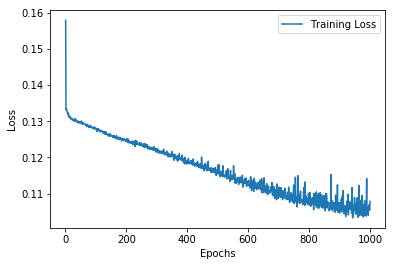

In [37]:
loss_values = history.history['loss']
epochs = range(1, len(loss_values)+1)

plt.plot(epochs, loss_values, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

https://www.kaggle.com/akashsri99/deep-learning-iris-dataset-keras

In [38]:
test_y_predictions = model.predict(test_X)

In [39]:
test_y_predictions[:10]

array([[7.5856280e-01, 2.4143717e-01],
       [9.9895239e-01, 1.0475651e-03],
       [9.5686299e-01, 4.3136995e-02],
       [1.0000000e+00, 0.0000000e+00],
       [9.8542529e-01, 1.4574680e-02],
       [1.0000000e+00, 2.1737091e-13],
       [9.9662328e-01, 3.3767601e-03],
       [8.2829630e-01, 1.7170373e-01],
       [8.6662048e-01, 1.3337952e-01],
       [9.9992788e-01, 7.2172195e-05]], dtype=float32)

In [40]:
test_y[:10]

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [41]:
y_test_class = np.argmax(test_y,axis=1)
y_pred_class = np.argmax(test_y_predictions,axis=1)

y_pred_class

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [42]:
y_test_class[:20]

array([0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [43]:
y_pred_class.shape

(648,)

In [44]:
assert y_test_class.shape == y_pred_class.shape

### Imbalanced classification problem
https://www.analyticsvidhya.com/blog/2017/03/imbalanced-classification-problem/
This happens because Machine Learning Algorithms are usually designed to improve accuracy by reducing the error. Thus, they do not take into account the class distribution / proportion or balance of classes.

[A Review of Class Imbalance Problem (Shaza M. Abd Elrahman and Ajith Abraham)](http://ias04.softcomputing.net/jnic2.pdf)

In [46]:
print(classification_report(y_test_class,y_pred_class))
print(confusion_matrix(y_test_class,y_pred_class))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98       619
           1       0.50      0.03      0.06        29

   micro avg       0.96      0.96      0.96       648
   macro avg       0.73      0.52      0.52       648
weighted avg       0.94      0.96      0.94       648

[[618   1]
 [ 28   1]]


In [48]:
from rouge_metrics import *
from get_sentences_from_line_numbers import *

predicted_line_numbers = [index_for_validation_test_split + index + 1 for index, value in enumerate(y_pred_class) if value==1]
summaries_line_numbers = [index_for_validation_test_split + index + 1 for index, value in enumerate(y_test_class) if value==1]

summaries_chat_lines = get_sentences_of_line_numbers(CHAT_LOGS, summaries_line_numbers)
predicted_chat_lines = get_sentences_of_line_numbers(CHAT_LOGS, predicted_line_numbers)
print("SUMMARIES\n---------\n", summaries_chat_lines)
print("PREDICTIONS\n-----------\n", predicted_chat_lines)

hypotheses = [predicted_chat_lines]
references = [summaries_chat_lines]
print("ROUGE Scores\n------------")
print_rouge_results(get_rouge_results(hypotheses, references))

SUMMARIES
---------
 btw, why are ou guys calling this abstraction thingy GComm when Dave has a project called GNU Comm (GComm fr short)?
as far as I'm concerned, GComm is our internal package name... to the external world, it's GNUe Common
but that is a good point
pyro is an object system like what gcomm will be
by same guys that wrote pygmy
the python email client
I need a production quality GNUe web shopping cart ;-)
anything is possible I know, but ideally we need to get ideas on some sort of php and GEAS interface
guess I'll just customize interchange.. hopefully actually have it done in a few days
our inventory package isn't completed
but if you have an inventory package
you should be able to access it via geas
I know a web interface for GNUe Forms is in the works, but I'm sure you need something relatively quickly
madlocke was working on that, but as you probably know, he's been out of commission (sick) lately
a new release (feature wise) is probably about 3 or 4 weeks away sinc

## Using a Recurrent Neural Network Instead
It seems that adding sentence vectors as windows around the sentence does not work well with a feed forward neural network

In [153]:
from keras.datasets import imdb
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence

In [283]:
# load the dataset but only keep the top n words, zero the rest
top_words = 5000
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=top_words)

In [294]:
print(X_train.shape)
print(len(X_train[0]))
print(X_test.shape)
X_train[0]

(25000,)
218
(25000,)


[1,
 14,
 22,
 16,
 43,
 530,
 973,
 1622,
 1385,
 65,
 458,
 4468,
 66,
 3941,
 4,
 173,
 36,
 256,
 5,
 25,
 100,
 43,
 838,
 112,
 50,
 670,
 2,
 9,
 35,
 480,
 284,
 5,
 150,
 4,
 172,
 112,
 167,
 2,
 336,
 385,
 39,
 4,
 172,
 4536,
 1111,
 17,
 546,
 38,
 13,
 447,
 4,
 192,
 50,
 16,
 6,
 147,
 2025,
 19,
 14,
 22,
 4,
 1920,
 4613,
 469,
 4,
 22,
 71,
 87,
 12,
 16,
 43,
 530,
 38,
 76,
 15,
 13,
 1247,
 4,
 22,
 17,
 515,
 17,
 12,
 16,
 626,
 18,
 2,
 5,
 62,
 386,
 12,
 8,
 316,
 8,
 106,
 5,
 4,
 2223,
 2,
 16,
 480,
 66,
 3785,
 33,
 4,
 130,
 12,
 16,
 38,
 619,
 5,
 25,
 124,
 51,
 36,
 135,
 48,
 25,
 1415,
 33,
 6,
 22,
 12,
 215,
 28,
 77,
 52,
 5,
 14,
 407,
 16,
 82,
 2,
 8,
 4,
 107,
 117,
 2,
 15,
 256,
 4,
 2,
 7,
 3766,
 5,
 723,
 36,
 71,
 43,
 530,
 476,
 26,
 400,
 317,
 46,
 7,
 4,
 2,
 1029,
 13,
 104,
 88,
 4,
 381,
 15,
 297,
 98,
 32,
 2071,
 56,
 26,
 141,
 6,
 194,
 2,
 18,
 4,
 226,
 22,
 21,
 134,
 476,
 26,
 480,
 5,
 144,
 30,
 2,
 18,
 51,
 36,
 

In [288]:
print(y_train.shape)
y_train

(25000,)


array([1, 0, 0, ..., 0, 1, 0])

In [295]:
# truncate and pad input sequences
max_review_length = 500
X_train = sequence.pad_sequences(X_train, maxlen=max_review_length)
X_test = sequence.pad_sequences(X_test, maxlen=max_review_length)

In [296]:
print(X_train.shape)
X_train[:5]

(25000, 500)


array([[   0,    0,    0, ...,   19,  178,   32],
       [   0,    0,    0, ...,   16,  145,   95],
       [   0,    0,    0, ...,    7,  129,  113],
       [ 687,   23,    4, ...,   21,   64, 2574],
       [   0,    0,    0, ...,    7,   61,  113]], dtype=int32)

In [292]:
print(y_train.shape)
y_train[:5]

(25000,)


array([1, 0, 0, 1, 0])

In [297]:
print(X_test.shape)
X_test[0]

(25000, 500)


array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   

In [159]:
# create the model
embedding_vecor_length = 32
imdb_model = Sequential()
imdb_model.add(Embedding(top_words, embedding_vecor_length, input_length=max_review_length))
imdb_model.add(LSTM(100))
imdb_model.add(Dense(1, activation='sigmoid'))
imdb_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(imdb_model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 500, 32)           160000    
_________________________________________________________________
lstm_36 (LSTM)               (None, 100)               53200     
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 101       
Total params: 213,301
Trainable params: 213,301
Non-trainable params: 0
_________________________________________________________________
None


In [160]:
imdb_history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=3, batch_size=64)

Train on 25000 samples, validate on 25000 samples
Epoch 1/3
25000/25000 [==============================] - 204s 8ms/step - loss: 0.5887 - acc: 0.6728 - val_loss: 0.5178 - val_acc: 0.7478
Epoch 2/3
25000/25000 [==============================] - 193s 8ms/step - loss: 0.3717 - acc: 0.8384 - val_loss: 0.3916 - val_acc: 0.8476
Epoch 3/3
25000/25000 [==============================] - 195s 8ms/step - loss: 0.2686 - acc: 0.8935 - val_loss: 0.3383 - val_acc: 0.8628


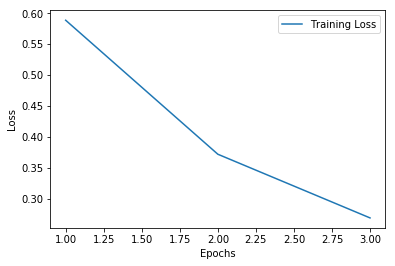

In [162]:
imdb_loss_values = imdb_history.history['loss']
imdb_epochs = range(1, len(imdb_loss_values)+1)

plt.plot(imdb_epochs, imdb_loss_values, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [223]:
from keras.layers import LSTM, Dropout

In [64]:
print(train_X.shape)
train_X.head()

(16079, 156)


,absolute_sentence_position,sentence_length,number_of_special_terms,sentiment_score,normalized_mean_tf_idf,normalized_mean_tf_isf,1,2,3,4,...,141,142,143,144,145,146,147,148,149,150
0,0.000436,0.013699,0.0,0.6249,0.006050,0.788992,8.923999e-08,-7.957217e-09,-5.274117e-09,-1.910836e-08,...,5.032557e-08,4.709798e-09,-7.814833e-08,3.333242e-08,-1.757239e-08,-4.967683e-09,3.275183e-08,-4.288362e-08,2.537755e-09,2.285525e-08
1,0.000871,0.178082,0.0,0.0000,0.026734,0.042729,1.138727e-09,-1.818176e-08,4.798956e-09,-5.157600e-08,...,3.880125e-08,-1.505285e-08,-3.228048e-08,6.559005e-08,2.989873e-08,-2.563377e-08,-3.230809e-08,-1.410832e-08,3.297067e-08,8.902228e-08
2,0.001307,0.136986,0.0,0.0000,0.031086,0.051728,-4.177528e-09,-1.188295e-08,2.389462e-08,-1.349990e-08,...,2.331976e-08,-2.124629e-08,-5.314322e-09,4.871865e-08,2.572267e-08,-1.130713e-08,-3.515117e-08,2.479115e-08,9.735289e-09,3.229467e-08
3,0.001743,0.068493,0.0,0.0000,0.027952,0.142905,-2.529559e-09,-1.465508e-08,8.994467e-09,8.784771e-09,...,2.564207e-08,1.737575e-09,2.070995e-08,-6.362434e-10,-2.201059e-08,2.865113e-08,-7.716492e-09,-3.310467e-08,-9.572791e-09,-1.052344e-08
4,0.002179,0.109589,0.0,0.2263,0.017715,0.084493,-2.828828e-10,4.331747e-10,8.529943e-11,-2.281351e-10,...,2.957617e-11,-1.465501e-10,1.223374e-10,1.708342e-10,3.674844e-10,1.448876e-10,6.751768e-10,1.813555e-10,6.316711e-10,-4.996572e-10


In [279]:
# A many to many RNN
#get number of columns in training data
embedding_vector_length = 32
num_of_cols = train_vectors_df.shape[1]
rnn_model = Sequential()
# rnn_model.add(Dense(num_of_cols, activation='relu', input_shape=(num_of_cols, 1)))
rnn_model.add(Embedding(train_vectors_df.shape[0], embedding_vector_length, input_length=num_of_cols))
rnn_model.add(Dropout(0.2))
rnn_model.add(LSTM(100))
rnn_model.add(Dropout(0.2))
rnn_model.add(Dense(1, activation='sigmoid'))

In [281]:
rnn_model.compile(
    loss="binary_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
)
rnn_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, 150, 32)           514528    
_________________________________________________________________
dropout_9 (Dropout)          (None, 150, 32)           0         
_________________________________________________________________
lstm_51 (LSTM)               (None, 100)               53200     
_________________________________________________________________
dropout_10 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_42 (Dense)             (None, 1)                 101       
Total params: 567,829
Trainable params: 567,829
Non-trainable params: 0
_________________________________________________________________


In [272]:
# rnn_history = rnn_model.fit(train_X, train_y, epochs=3, batch_size=64)
rnn_start = time.time()
rnn_history = rnn_model.fit(
    train_vectors_df, 
    train_y_nums, 
    validation_data=(validation_vectors_df, validation_y_nums), 
    epochs=10, 
    batch_size=64
)
rnn_end = time.time()
print(rnn_end - rnn_start, "seconds")

Train on 16079 samples, validate on 3988 samples
Epoch 1/10
16079/16079 [==============================] - 35s 2ms/step - loss: 0.1416 - acc: 0.9684 - val_loss: 0.1325 - val_acc: 0.9709
Epoch 2/10
16079/16079 [==============================] - 36s 2ms/step - loss: 0.1414 - acc: 0.9684 - val_loss: 0.1323 - val_acc: 0.9709
Epoch 3/10
16079/16079 [==============================] - 36s 2ms/step - loss: 0.1413 - acc: 0.9684 - val_loss: 0.1333 - val_acc: 0.9709
Epoch 4/10
16079/16079 [==============================] - 36s 2ms/step - loss: 0.1415 - acc: 0.9684 - val_loss: 0.1316 - val_acc: 0.9709
Epoch 5/10
16079/16079 [==============================] - 35s 2ms/step - loss: 0.1413 - acc: 0.9684 - val_loss: 0.1316 - val_acc: 0.9709
Epoch 6/10
16079/16079 [==============================] - 36s 2ms/step - loss: 0.1410 - acc: 0.9684 - val_loss: 0.1316 - val_acc: 0.9709
Epoch 7/10
16079/16079 [==============================] - 36s 2ms/step - loss: 0.1409 - acc: 0.9684 - val_loss: 0.1321 - val_acc:

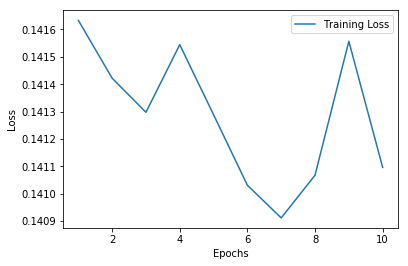

In [273]:
rnn_loss_values = rnn_history.history['loss']
rnn_epochs = range(1, len(rnn_loss_values)+1)

plt.plot(rnn_epochs, rnn_loss_values, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [274]:
rnn_test_y_predictions = rnn_model.predict(validation_vectors_df)

In [275]:
rnn_test_y_predictions[:]

array([[0.03626591],
       [0.03626591],
       [0.03626591],
       ...,
       [0.03626592],
       [0.03626592],
       [0.03626592]], dtype=float32)

In [276]:
validation_y[:10]

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [277]:
rnn_y_test_class = np.argmax(test_y,axis=1)
rnn_y_pred_class = np.argmax(rnn_test_y_predictions,axis=1)

assert y_test_class.shape == y_pred_class.shape
print(rnn_y_pred_class.shape)
print(rnn_y_pred_class)

(3988,)
[0 0 0 ... 0 0 0]


In [278]:
print(classification_report(validation_y_nums,rnn_y_pred_class))
print(confusion_matrix(validation_y_nums,rnn_y_pred_class))

              precision    recall  f1-score   support

           0       0.97      1.00      0.99      3872
           1       0.00      0.00      0.00       116

   micro avg       0.97      0.97      0.97      3988
   macro avg       0.49      0.50      0.49      3988
weighted avg       0.94      0.97      0.96      3988

[[3872    0]
 [ 116    0]]


In [ ]:
# rnn_history = rnn_model.fit(train_X, train_y, epochs=3, batch_size=64)
rnn_start = time.time()
rnn_history = rnn_model.fit(
    train_X, 
    train_y_nums, 
    validation_data=(validation_X, validation_y_nums), 
    epochs=100, 
    batch_size=64
)
rnn_end = time.time()
print(rnn_end - rnn_start, "seconds")

Train on 16079 samples, validate on 3988 samples
Epoch 1/100
 9728/16079 [=================>............] - ETA: 14s - loss: 0.1351 - acc: 0.9704